In [1]:
import os
import sys
import cv2
import sympy as sp
import numpy as np
import pickle
import glob
import difflib
from scipy import stats
from pprint import pprint
from typing import Dict, Tuple, Sequence

#UTILS
sys.path.append('./Calib') #NEED TO POINT THIS TO THE Calib MODULE FOLDER!!!
from calib import calib, app, extract, utils, plotting

#GUI
from PyQt5.QtWidgets import QApplication, QGridLayout, QSizePolicy
from PyQt5 import QtGui, QtCore
import pyqtgraph.opengl as gl
import pyqtgraph

#MPL
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt
import matplotlib.animation as ani

#PYOMO
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Pose Functions

In [2]:
#SYMBOLIC ROTATION MATRIX FUNCTIONS
def rot_x(x):
    c = sp.cos(x)
    s = sp.sin(x)
    return sp.Matrix([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def rot_y(y):
    c = sp.cos(y)
    s = sp.sin(y)
    return sp.Matrix([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def rot_z(z):
    c = sp.cos(z)
    s = sp.sin(z)
    return sp.Matrix([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

In [3]:
L = 14  #number of joints in the cheetah model

# defines arrays ofa angles, velocities and accelerations
phi     = [sp.symbols(f"\\phi_{{{l}}}")   for l in range(L)]
theta   = [sp.symbols(f"\\theta_{{{l}}}") for l in range(L)]
psi     = [sp.symbols(f"\\psi_{{{l}}}")   for l in range(L)]

#ROTATIONS
# head
RI_0 = rot_z(psi[0]) @ rot_x(phi[0]) @ rot_y(theta[0])
R0_I = RI_0.T
# neck
RI_1 = rot_z(psi[1]) @ rot_x(phi[1]) @ rot_y(theta[1]) @ RI_0
R1_I = RI_1.T
# front torso
RI_2 = rot_y(theta[2]) @ RI_1
R2_I = RI_2.T
# back torso
RI_3 = rot_z(psi[3]) @ rot_y(theta[3]) @ RI_2
R3_I = RI_3.T
# tail base
RI_4 = rot_z(psi[4]) @ rot_y(theta[4]) @ RI_3
R4_I = RI_4.T
# tail mid
RI_5 = rot_z(psi[5]) @ rot_y(theta[5]) @ RI_4
R5_I = RI_5.T
#l_shoulder
RI_6 = rot_y(theta[6]) @ RI_2
R6_I = RI_6.T
#l_front_knee
RI_7 = rot_y(theta[7]) @ RI_6
R7_I = RI_7.T
#r_shoulder
RI_8 = rot_y(theta[8]) @ RI_2
R8_I = RI_8.T
#r_front_knee
RI_9 = rot_y(theta[9]) @ RI_8
R9_I = RI_9.T
#l_hip
RI_10 = rot_y(theta[10]) @ RI_3
R10_I = RI_10.T
#l_back_knee
RI_11 = rot_y(theta[11]) @ RI_10
R11_I = RI_11.T
#r_hip
RI_12 = rot_y(theta[12]) @ RI_3
R12_I = RI_12.T
#r_back_knee
RI_13 = rot_y(theta[13]) @ RI_12
R13_I = RI_13.T

In [4]:
# defines the position, velocities and accelerations in the inertial frame
x,   y,   z   = sp.symbols("x y z")
dx,  dy,  dz  = sp.symbols("\\dot{x} \\dot{y} \\dot{z}")
ddx, ddy, ddz = sp.symbols("\\ddot{x} \\ddot{y} \\ddot{z}")


# SYMBOLIC CHEETAH POSE POSITIONS
p_head          = sp.Matrix([x, y, z])

p_l_eye         = p_head         + R0_I  @ sp.Matrix([0, 0.03, 0])
p_r_eye         = p_head         + R0_I  @ sp.Matrix([0, -0.03, 0])
p_nose          = p_head         + R0_I  @ sp.Matrix([0.055, 0, -0.055])

p_neck_base     = p_head         + R1_I  @ sp.Matrix([-0.28, 0, 0])
p_spine         = p_neck_base    + R2_I  @ sp.Matrix([-0.37, 0, 0])
p_tail_base     = p_spine        + R3_I  @ sp.Matrix([-0.37, 0, 0])
p_tail_mid      = p_tail_base    + R4_I  @ sp.Matrix([-0.28, 0, 0])
p_tail_tip      = p_tail_mid     + R5_I  @ sp.Matrix([-0.36, 0, 0])

p_l_shoulder    = p_neck_base    + R2_I  @ sp.Matrix([-0.04, 0.08, -0.10])
p_l_front_knee  = p_l_shoulder   + R6_I  @ sp.Matrix([0, 0, -0.24])
p_l_front_ankle = p_l_front_knee + R7_I  @ sp.Matrix([0, 0, -0.28])

p_r_shoulder    = p_neck_base    + R2_I  @ sp.Matrix([-0.04, -0.08, -0.10])
p_r_front_knee  = p_r_shoulder   + R8_I  @ sp.Matrix([0, 0, -0.24])
p_r_front_ankle = p_r_front_knee + R9_I  @ sp.Matrix([0, 0, -0.28])

p_l_hip         = p_tail_base    + R3_I  @ sp.Matrix([0.12, 0.08, -0.06])
p_l_back_knee   = p_l_hip        + R10_I @ sp.Matrix([0, 0, -0.32])
p_l_back_ankle  = p_l_back_knee  + R11_I @ sp.Matrix([0, 0, -0.25])

p_r_hip         = p_tail_base    + R3_I  @ sp.Matrix([0.12, -0.08, -0.06])
p_r_back_knee   = p_r_hip        + R12_I @ sp.Matrix([0, 0, -0.32])
p_r_back_ankle  = p_r_back_knee  + R13_I @ sp.Matrix([0, 0, -0.25])

# Lambdify symbolic functions

In [5]:
positions = sp.Matrix([
    p_l_eye.T,
    p_r_eye.T,
    p_nose.T,
    p_neck_base.T,
    p_spine.T,
    p_tail_base.T,
    p_tail_mid.T,
    p_tail_tip.T,
    p_l_shoulder.T,
    p_l_front_knee.T,
    p_l_front_ankle.T,
    p_r_shoulder.T,
    p_r_front_knee.T,
    p_r_front_ankle.T,
    p_l_hip.T,
    p_l_back_knee.T,
    p_l_back_ankle.T,
    p_r_hip.T,
    p_r_back_knee.T,
    p_r_back_ankle.T,
])

In [6]:
func_map = {"sin":sin, "cos":cos, "ImmutableDenseMatrix":np.array} 
sym_list = [x, y, z, *phi, *theta, *psi]
pose_to_3d = sp.lambdify(sym_list, positions, modules=[func_map])
pos_funcs = []
for i in range(positions.shape[0]):
    lamb = sp.lambdify(sym_list, positions[i,:], modules=[func_map])
    pos_funcs.append(lamb)

# Projection Functions

In [7]:
#NUMPY ROTATION MATRIX FUNCTIONS
def np_rot_x(x):
    c = np.cos(x)
    s = np.sin(x)
    return np.array([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def np_rot_y(y):
    c = np.cos(y)
    s = np.sin(y)
    return np.array([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def np_rot_z(z):
    c = np.cos(z)
    s = np.sin(z)
    return np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

In [8]:
def pt3d_to_2d(x, y, z, K, D, R, t):
    x_2d = x*R[0,0] + y*R[0,1] + z*R[0,2] + t.flatten()[0]
    y_2d = x*R[1,0] + y*R[1,1] + z*R[1,2] + t.flatten()[1]
    z_2d = x*R[2,0] + y*R[2,1] + z*R[2,2] + t.flatten()[2]
    #project onto camera plane
    a = x_2d/z_2d
    b = y_2d/z_2d
    #fisheye params
    r = (a**2 + b**2 +1e-12)**0.5 
    th = atan(r)
    #distortion
    th_D = th * (1 + D[0]*th**2 + D[1]*th**4 + D[2]*th**6 + D[3]*th**8)
    x_P = a*th_D/r
    y_P = b*th_D/r
    u = K[0,0]*x_P + K[0,2]
    v = K[1,1]*y_P + K[1,2]
    return u, v

def pt3d_to_x2d(x, y, z, K, D, R, t):
    u = pt3d_to_2d(x, y, z, K, D, R, t)[0]
    return u

def pt3d_to_y2d(x, y, z, K, D, R, t):
    v = pt3d_to_2d(x, y, z, K, D, R, t)[1]
    return v

# Robust Cost Function

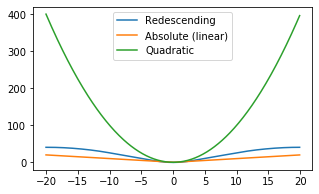

In [9]:
#OUTLIER REJECTING COST FUNCTION (REDESCENDING LOSS)
def func_step(start, x):
        return 1/(1+np.e**(-1*(x - start)))

def func_piece(start, end, x):
        return func_step(start, x) - func_step(end, x)
    
def redescending_loss(err, a, b, c):
    e = abs(err)
    cost = 0.0
    cost += (1 - func_step(a, e))/2*e**2
    cost += func_piece(a, b, e)*(a*e - (a**2)/2)
    cost += func_piece(b, c, e)*(a*b - (a**2)/2 + (a*(c-b)/2)*(1-((c-e)/(c-b))**2))
    cost += func_step(c, e)*(a*b - (a**2)/2 + (a*(c-b)/2))
    return cost


# PLOT OF REDESCENDING, ABSOLUTE AND QUADRATIC COST FUNCTIONS
# we use a redescending cost to stop outliers affecting the optimisation negatively
redesc_a = 3
redesc_b = 10
redesc_c = 20

#Plot
r_x = np.arange(-20,20, 1e-1)
r_y1 = [redescending_loss(i, redesc_a, redesc_b, redesc_c) for i in r_x]
r_y2 = abs(r_x)
r_y3 = r_x**2
plt.figure(figsize=(5,3))
plt.plot(r_x,r_y1, label="Redescending")
plt.plot(r_x,r_y2, label="Absolute (linear)")
plt.plot(r_x,r_y3, label="Quadratic")
ax = plt.gca()
# ax.set_ylim((-1e3, 5e4))
ax.legend()

# Generate All The 3D Reconstruction Data

In [10]:
def convert_to_dict(m) -> Dict:
    x_optimised = []
    dx_optimised = []
    ddx_optimised = []
    for n in range(1, N+1):
        x_optimised.append([value(m.x[n, p]) for p in range(1,P+1)])
        dx_optimised.append([value(m.dx[n, p]) for p in range(1,P+1)])
        ddx_optimised.append([value(m.ddx[n, p]) for p in range(1,P+1)])
    x_optimised = np.array(x_optimised)
    dx_optimised = np.array(dx_optimised)
    ddx_optimised = np.array(ddx_optimised)
    
    positions = np.array([pose_to_3d(*states) for states in x_optimised])
    file_data = dict(
        positions=positions,
        x=x_optimised,
        dx=dx_optimised,
        ddx=ddx_optimised,
    )
    return file_data

def save_data(file_data, file_path, dict=False) -> None:
    if dict:
        file_data = convert_to_dict(file_data)
        
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with open(file_path, 'wb') as f:
        pickle.dump(file_data, f)
    
    print(f'save {file_path}')

In [11]:
# Import Data
markers = dict(enumerate([
    "l_eye",
    "r_eye",
    "nose",
    "neck_base",
    "spine",
    "tail_base",
    "tail1",
    "tail2",
    "l_shoulder",
    "l_front_knee",
    "l_front_ankle",
    "r_shoulder",
    "r_front_knee",
    "r_front_ankle",
    "l_hip",
    "l_back_knee",
    "l_back_ankle",
    "r_hip",
    "r_back_knee",
    "r_back_ankle"
]))

def get_meas_from_df(n, c, l, d):
    n_mask = points_2d_df["frame"]== n-1
    l_mask = points_2d_df["marker"]== markers[l-1]
    c_mask = points_2d_df["camera"]== c-1
    d_idx = {1:"x", 2:"y"}
    val = points_2d_df[n_mask & l_mask & c_mask]
    return val[d_idx[d]].values[0]

def get_likelihood_from_df(n, c, l):
    n_mask = points_2d_df["frame"]== n-1
    l_mask = points_2d_df["marker"]== markers[l-1]
    c_mask = points_2d_df["camera"]== c-1
    val = points_2d_df[n_mask & l_mask & c_mask]
    return val["likelihood"].values[0]




Loading ../data/27_02_2019/Kiara_dlc_result/Flick
Found 2231 pairwise points between camera 0 and 1
Found 2920 pairwise points between camera 1 and 2
Found 1949 pairwise points between camera 2 and 3
Found 2609 pairwise points between camera 3 and 4
Found 1962 pairwise points between camera 4 and 5
Started Optimisation
Solver log file: '../logs/solver.log'
Solver solution file: '/var/folders/f8/049wsyt52n3d54ts369x0dd00000gn/T/tmpun69d2v_.pyomo.sol'
Solver problem files: ('/var/folders/f8/049wsyt52n3d54ts369x0dd00000gn/T/tmpun69d2v_.pyomo.nl',)
Ipopt 3.13.2: print_level=5
max_iter=10000
max_cpu_time=3600
tol=0.1
option_file_name=/var/folders/f8/049wsyt52n3d54ts369x0dd00000gn/T/tmplrlivwt3_ipopt.opt

Using option file "/var/folders/f8/049wsyt52n3d54ts369x0dd00000gn/T/tmplrlivwt3_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source co

AssertionError: prepare all the data of 6 cameras

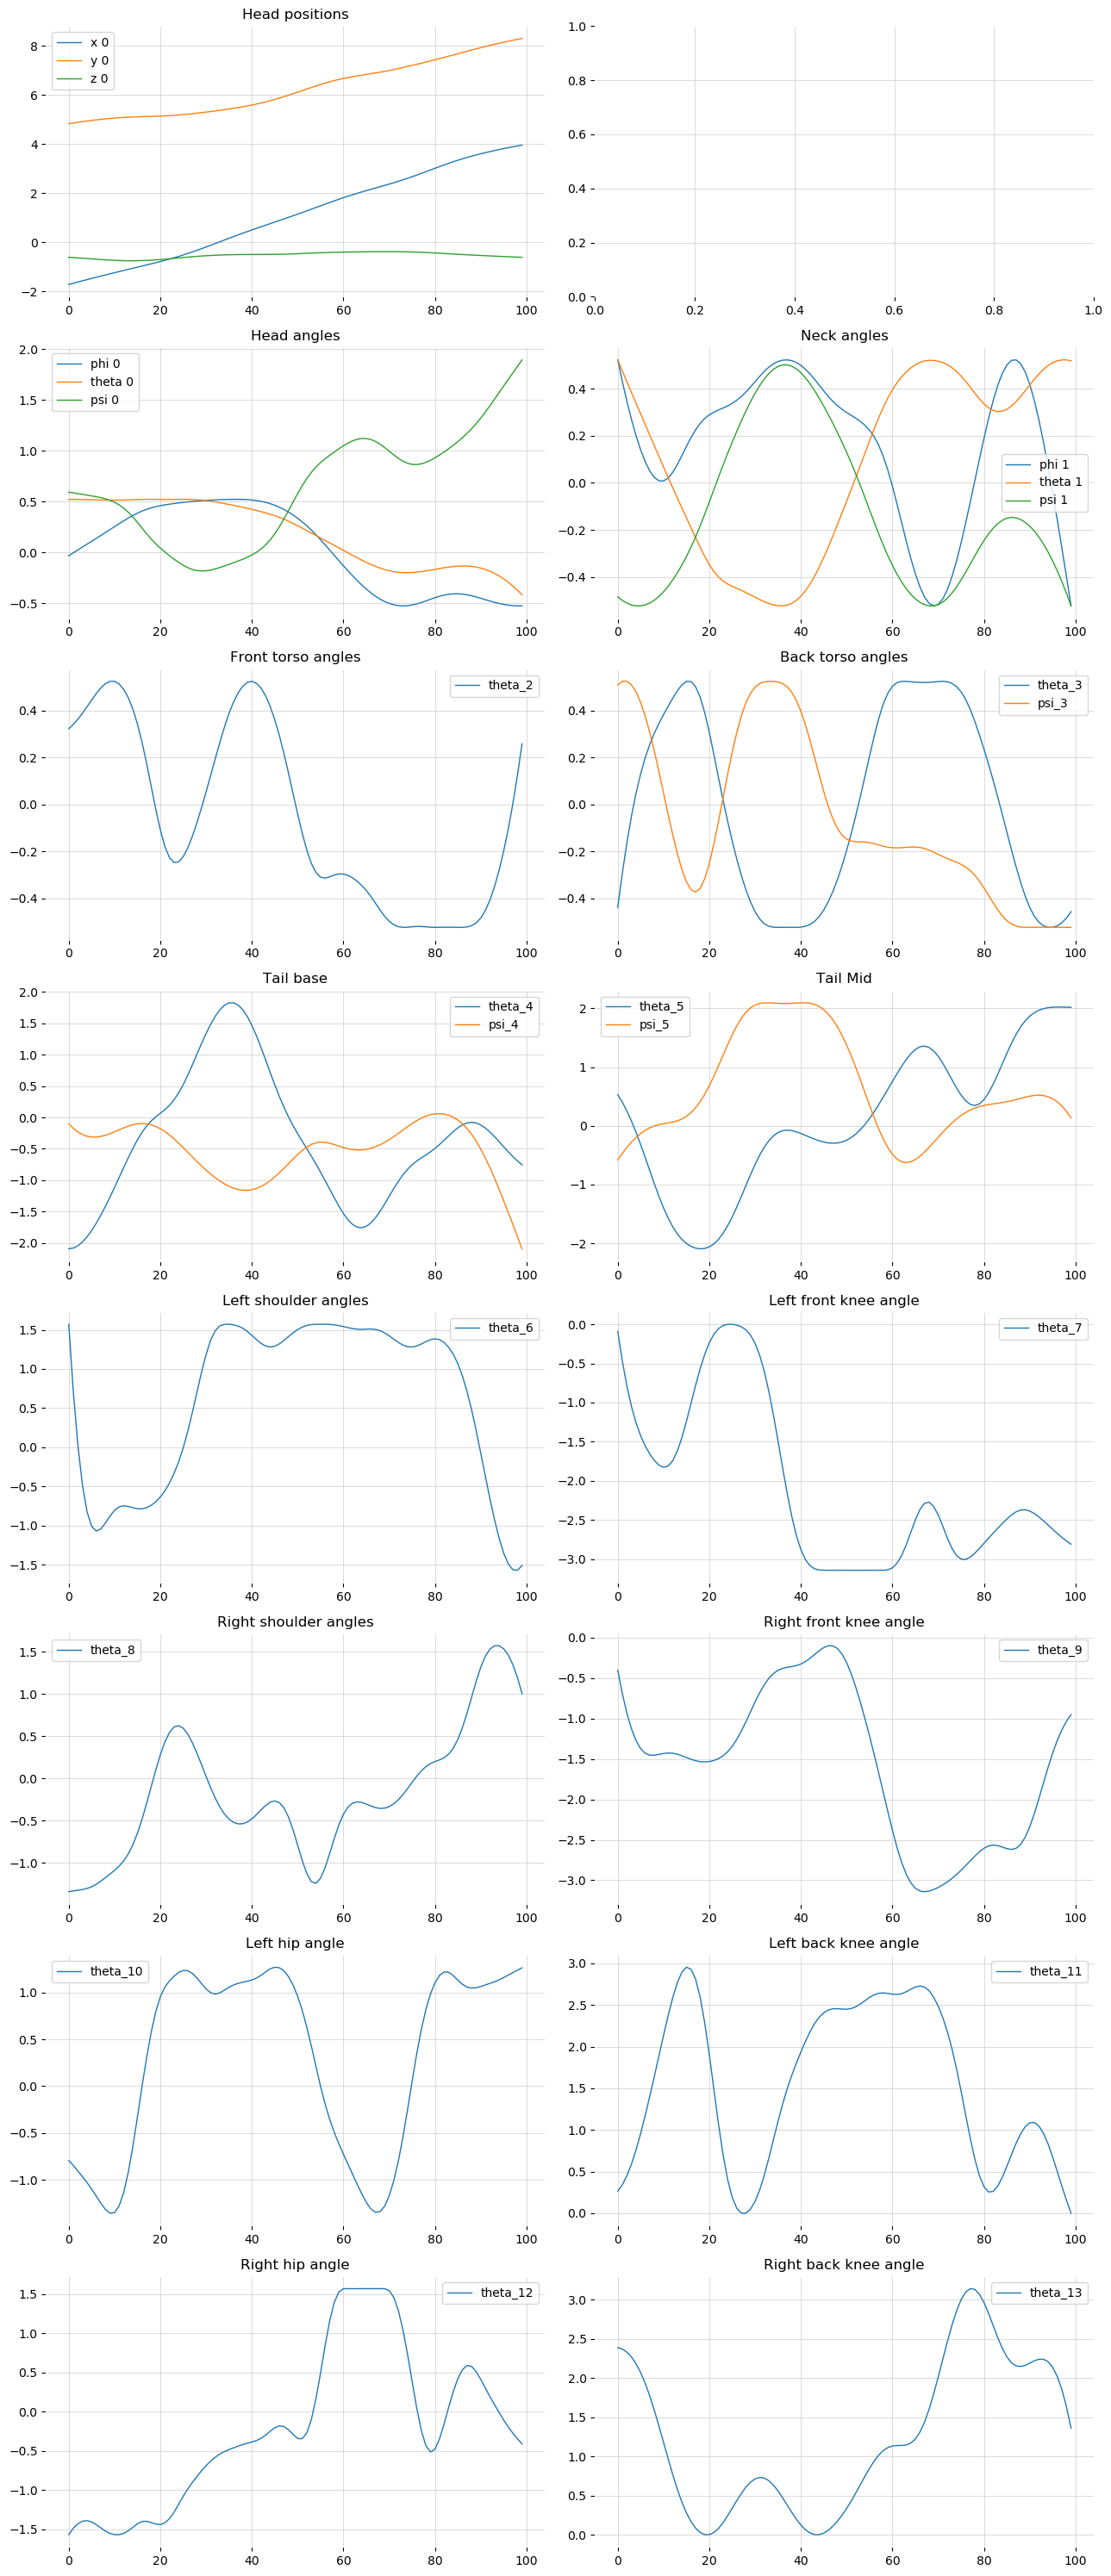

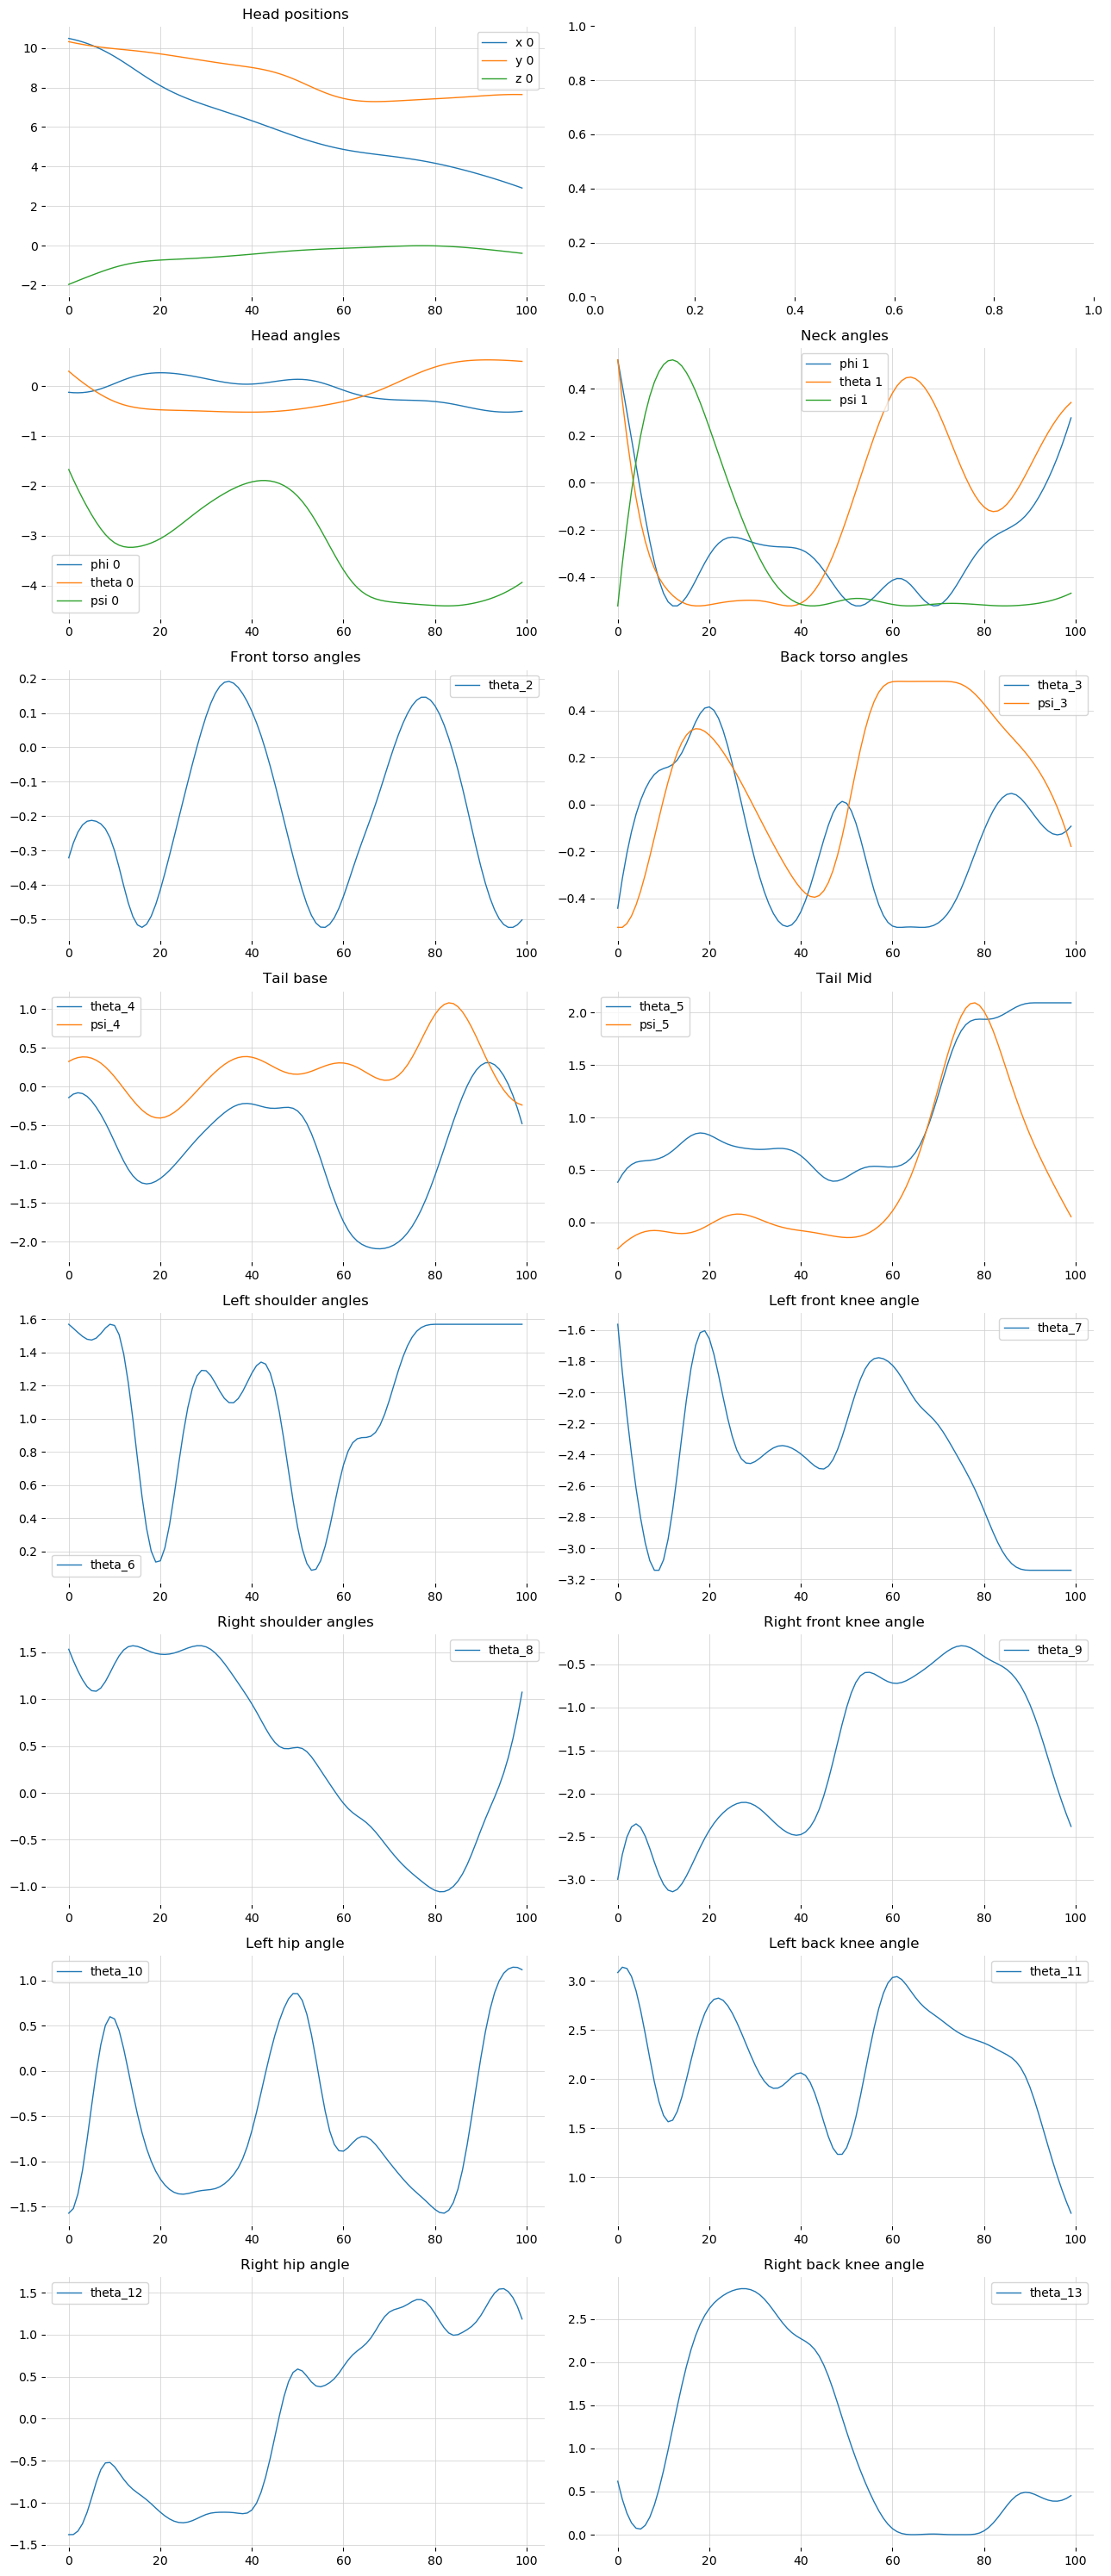

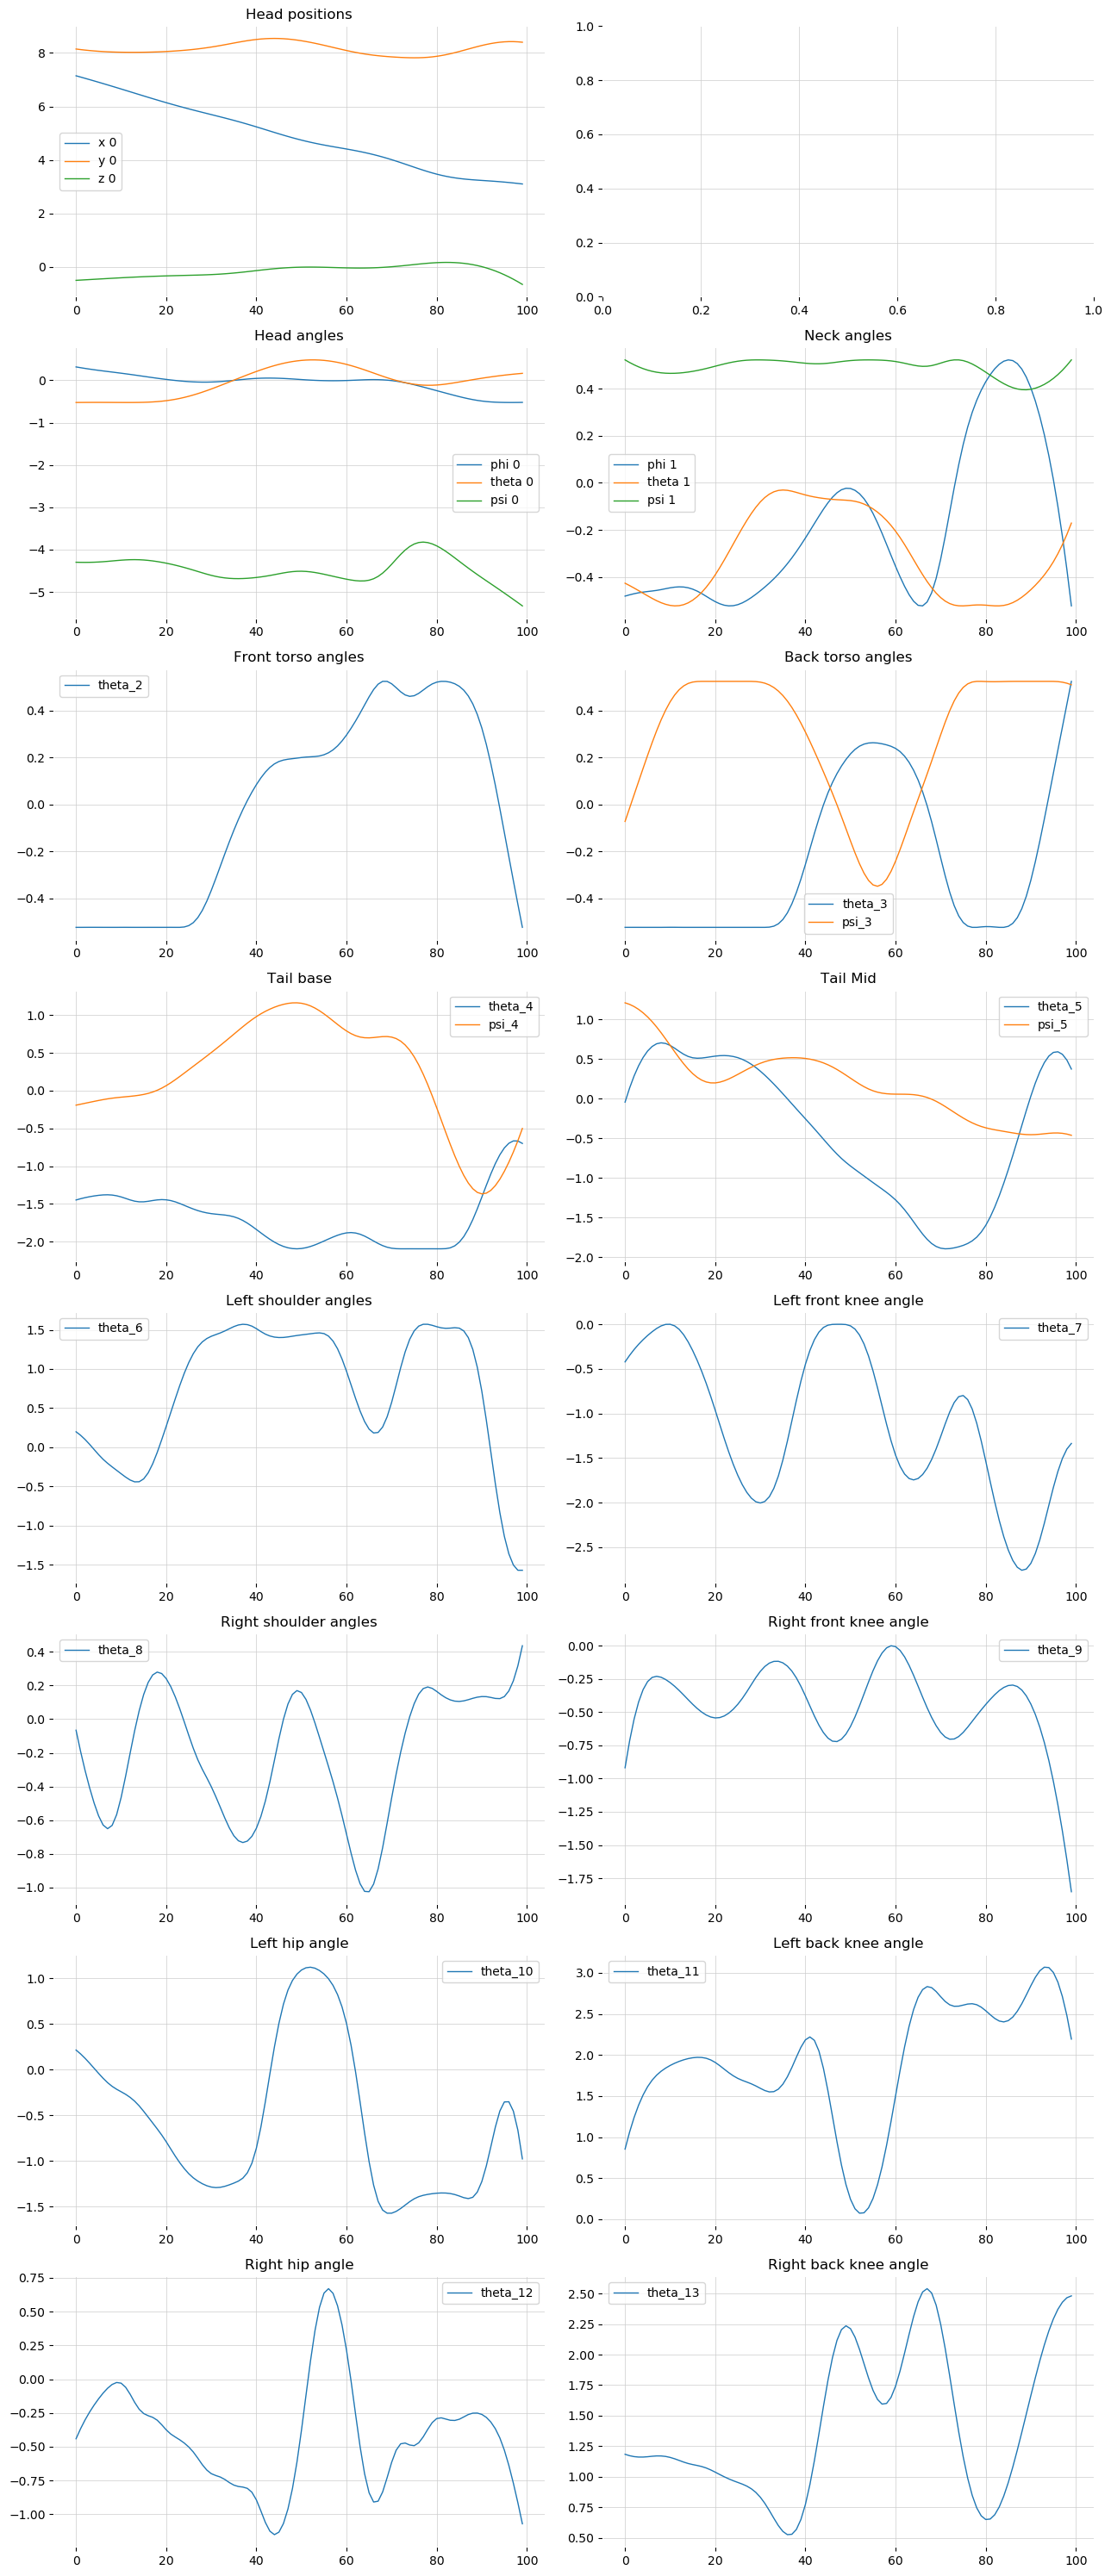

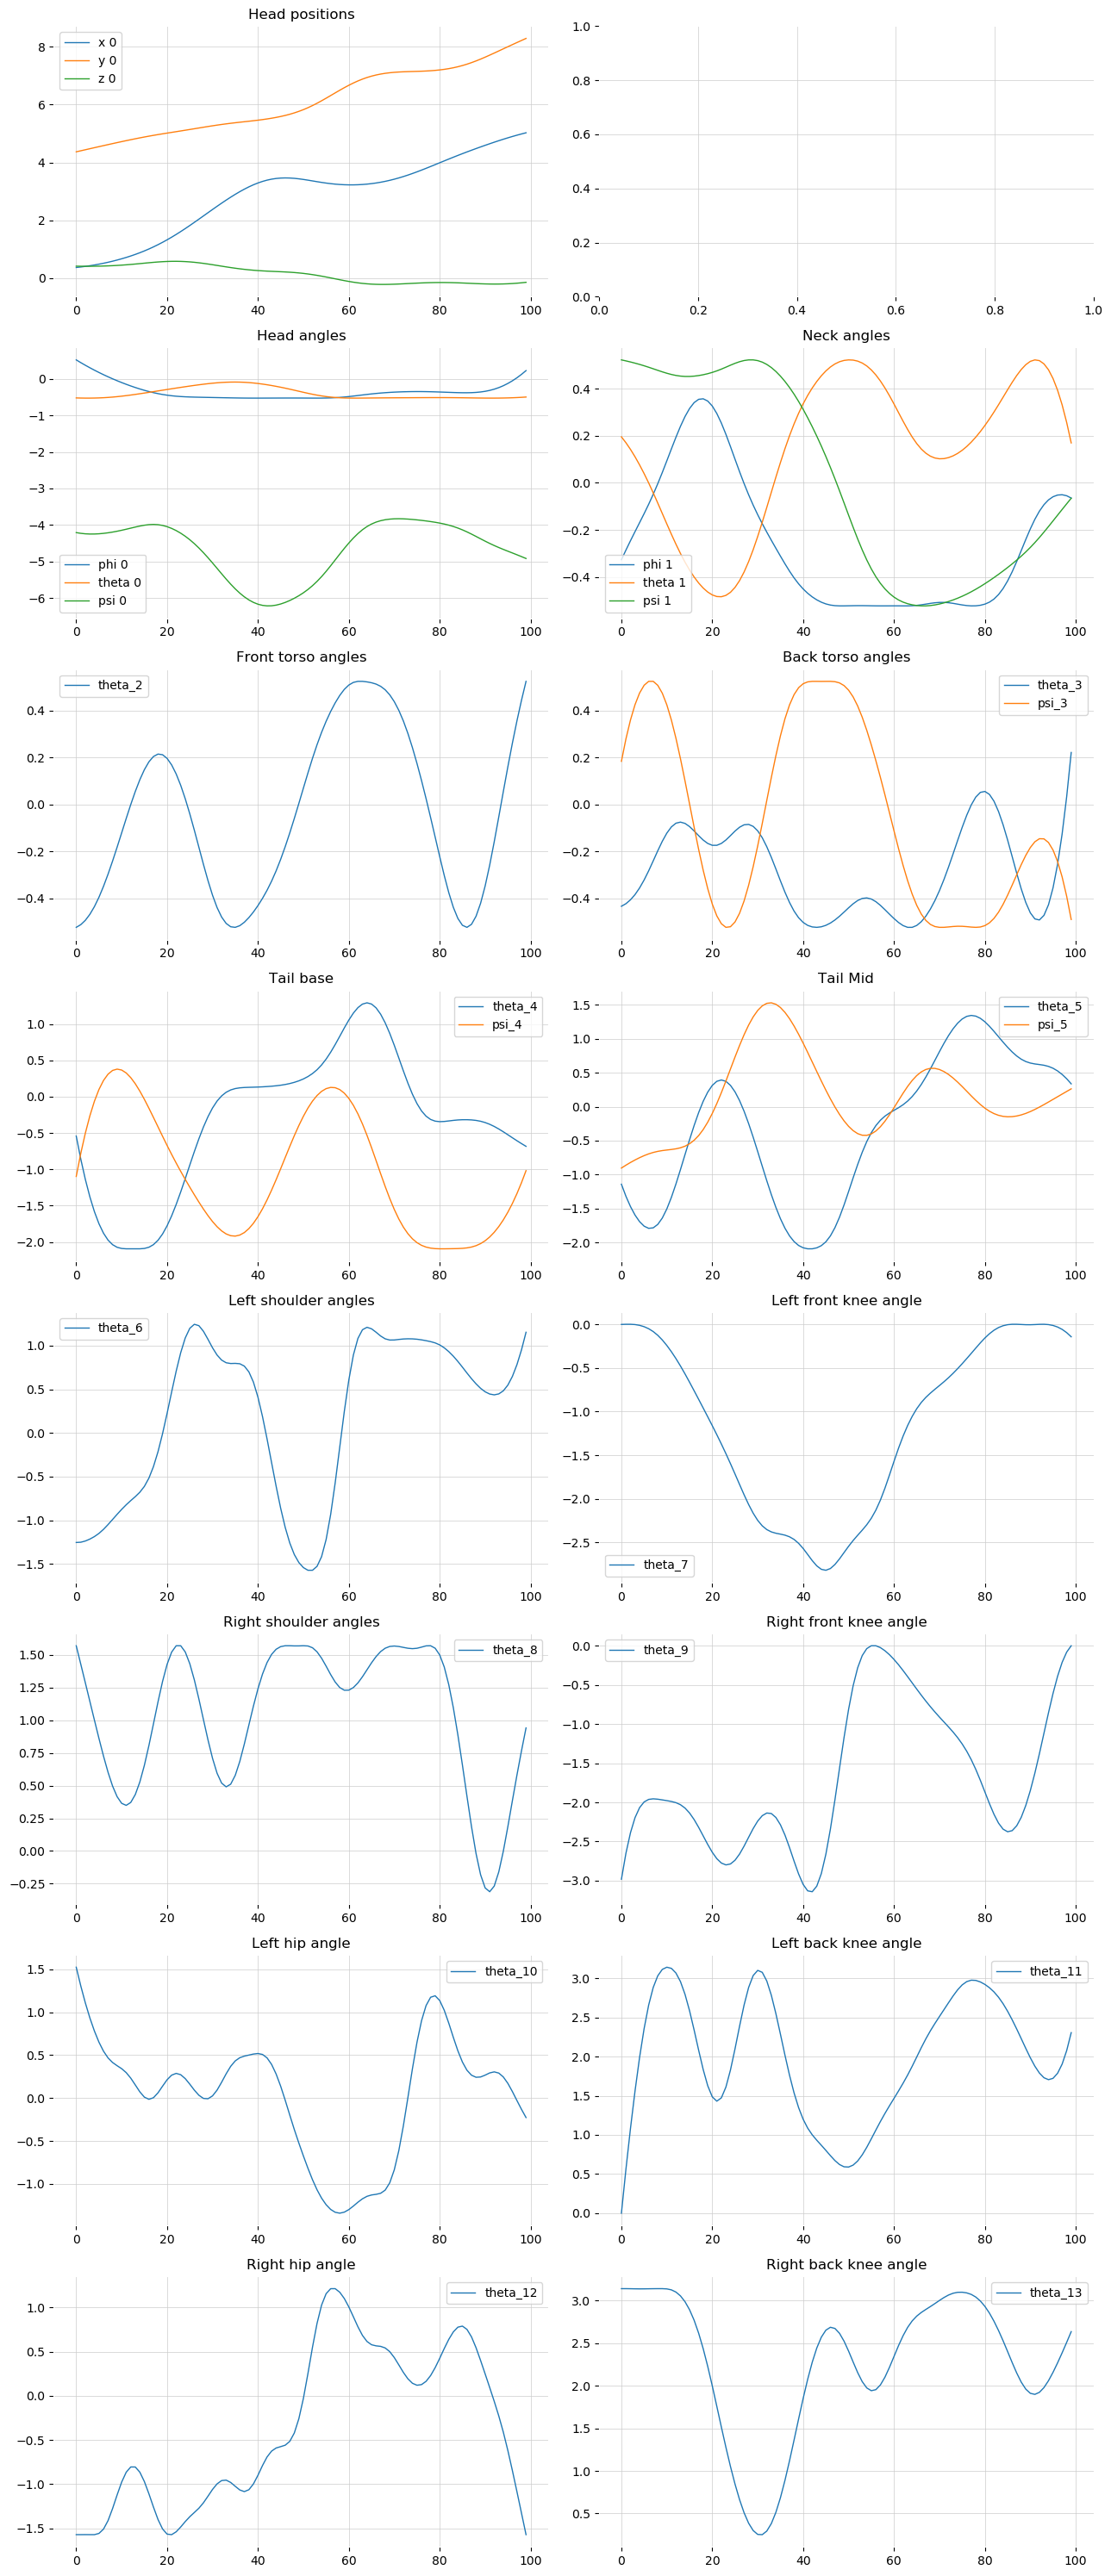

In [12]:
NUM_CAMERA = 6
LOG_DIR = '../logs'
CONFIG_DIR = '../configs'
DATA_ROOT_DIR = '../data'
data_dirs = [
#     os.path.join(DATA_ROOT_DIR, '05_03_2019'),    # camera 4&5 were overheated
    os.path.join(DATA_ROOT_DIR, '27_02_2019'),    # lacking shared frames of extrinsic calibration
#     os.path.join(DATA_ROOT_DIR, '07_03_2019'),    # camera 6 was bumped
#     os.path.join(DATA_ROOT_DIR, '09_03_2019'),
]

# main loop
for data_dir in data_dirs:
    scene_fpath = os.path.join(data_dir, "extrinsic_calibration/scene_sba.json")

    # === Import Camera and Scene Parameters ===
    K_arr, D_arr, R_arr, t_arr, _ = utils.load_scene(scene_fpath)
    D_arr = D_arr.reshape((-1,4))


    # === Optimisation ===

    # Parameters
    h = 1/120 #timestep
    start_frame = 30 # 50
    N = 100
    P = 3 + len(phi)+len(theta)+len(psi)
    L = len(pos_funcs)
    C = len(K_arr)
    D2 = 2
    D3 = 3

    proj_funcs = [pt3d_to_x2d, pt3d_to_y2d]

    R = 5 # measurement standard deviation
    Q = np.array([ # model parameters variance
        4.0,
        7.0,
        5.0,
        13.0,
        32.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        9.0,
        18.0,
        43.0,
        53.0,
        90.0,
        118.0,
        247.0,
        186.0,
        194.0,
        164.0,
        295.0,
        243.0,
        334.0,
        149.0,
        26.0,
        12.0,
        0.0,
        34.0,
        43.0,
        51.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ])**2


    dlc_result_dirs = sorted(glob.glob(os.path.join(data_dir, '*_dlc_result/*')))

    for dlc_result_dir in dlc_result_dirs:
        result_dir = os.path.join(dlc_result_dir, 'full_traj')

        # check if the dir includes h5 files
        if len(glob.glob(os.path.join(dlc_result_dir, '*.h5'))) == 0:
            continue
            
        # check if the dir has figure.png
        if os.path.exists(os.path.join(result_dir, 'figure.pdf')):
            continue

        #===================================================
        #                   Load in data
        #===================================================
        print(f"\n\n\nLoading {dlc_result_dir}")
        df_paths = sorted(glob.glob(os.path.join(dlc_result_dir, '*.h5')))
        assert len(df_paths) == NUM_CAMERA, f'prepare all the data of {NUM_CAMERA} cameras'

        points_2d_df = utils.create_dlc_points_2d_file(df_paths)
        triangulate_func = calib.triangulate_points_fisheye
        points_2d_filtered_df = points_2d_df[points_2d_df['likelihood'] > 0.5]
        points_3d_df = calib.get_pairwise_3d_points_from_df(
            points_2d_filtered_df, K_arr, D_arr, R_arr, t_arr, triangulate_func)

        # estimate initial points
        nose_pts = points_3d_df[points_3d_df["marker"]=="nose"][["x", "y", "z", "frame"]].values
        x_slope, x_intercept, *_ = stats.linregress(nose_pts[:,3], nose_pts[:,0])
        y_slope, y_intercept, *_ = stats.linregress(nose_pts[:,3], nose_pts[:,1])
        z_slope, z_intercept, *_ = stats.linregress(nose_pts[:,3], nose_pts[:,2])
        frame_est = np.arange(N)
        x_est = frame_est*x_slope + x_intercept
        y_est = frame_est*y_slope + y_intercept
        z_est = frame_est*z_slope + z_intercept
        psi_est = np.arctan2(y_slope, x_slope)

        #===================================================
        #                   Optimisation
        #===================================================
        print("Started Optimisation")
        m = ConcreteModel(name="Cheetah from measurements")

        # ===== SETS =====
        m.N = RangeSet(N) #number of timesteps in trajectory
        m.P = RangeSet(P) #number of pose parameters (x, y, z, phi_1..n, theta_1..n, psi_1..n)
        m.L = RangeSet(L) #number of labels
        m.C = RangeSet(C) #number of cameras
        m.D2 = RangeSet(D2) #dimensionality of measurements
        m.D3 = RangeSet(D3) #dimensionality of measurements

        # ===== WEIGHTS =====
        def init_meas_weights(m, n, c, l):
            likelihood = get_likelihood_from_df(n+start_frame, c, l)
            if likelihood > 0.5:
                return 1/R
            else:
                return 0
        m.meas_err_weight = Param(m.N, m.C, m.L, initialize=init_meas_weights, mutable=True)

        def init_model_weights(m, p):
            if Q[p-1] != 0.0:
                return 1/Q[p-1]
            else:
                return 0
        m.model_err_weight = Param(m.P, initialize=init_model_weights)

        # ===== PARAMETERS =====
        m.h = h

        def init_measurements_df(m, n, c, l, d2):
            return get_meas_from_df(n+start_frame, c, l, d2)
        m.meas = Param(m.N, m.C, m.L, m.D2, initialize=init_measurements_df)

        # ===== VARIABLES =====
        m.x = Var(m.N, m.P) #position
        m.dx = Var(m.N, m.P) #velocity
        m.ddx = Var(m.N, m.P) #acceleration
        m.poses = Var(m.N, m.L, m.D3)
        m.slack_model = Var(m.N, m.P)
        m.slack_meas = Var(m.N, m.C, m.L, m.D2, initialize=0.0)


        # ===== VARIABLES INITIALIZATION =====
        init_x = np.zeros((N-start_frame, P))
        init_x[:,0] = x_est[start_frame: start_frame+N]#x
        init_x[:,1] = y_est[start_frame: start_frame+N] #y
        init_x[:,2] = z_est[start_frame: start_frame+N] #z
        init_x[:,31] = psi_est #yaw - psi
        init_dx = np.zeros((N, P))
        init_ddx = np.zeros((N, P))
        for n in range(1,N+1):
            for p in range(1,P+1):
                if n<len(init_x): #init using known values
                    m.x[n,p].value = init_x[n-1,p-1]
                    m.dx[n,p].value = init_dx[n-1,p-1]
                    m.ddx[n,p].value = init_ddx[n-1,p-1]
                else: #init using last known value
                    m.x[n,p].value = init_x[-1,p-1]
                    m.dx[n,p].value = init_dx[-1,p-1]
                    m.ddx[n,p].value = init_ddx[-1,p-1]
            #init pose
            var_list = [m.x[n,p].value for p in range(1, P+1)]
            for l in range(1,L+1):
                [pos] = pos_funcs[l-1](*var_list)
                for d3 in range(1,D3+1):
                    m.poses[n,l,d3].value = pos[d3-1]


        # ===== CONSTRAINTS =====
        # 3D POSE
        def pose_constraint(m,n,l,d3):
            #get 3d points
            var_list = [m.x[n,p] for p in range(1, P+1)]
            [pos] = pos_funcs[l-1](*var_list)
            return pos[d3-1] == m.poses[n,l,d3]
        m.pose_constraint = Constraint(m.N, m.L, m.D3, rule = pose_constraint)

        # INTEGRATION
        def backwards_euler_pos(m,n,p): # position
            if n > 1:
        #             return m.x[n,p] == m.x[n-1,p] + m.h*m.dx[n-1,p] + m.h**2 * m.ddx[n-1,p]/2
                return m.x[n,p] == m.x[n-1,p] + m.h*m.dx[n,p]

            else:
                return Constraint.Skip
        m.integrate_p = Constraint(m.N, m.P, rule = backwards_euler_pos)


        def backwards_euler_vel(m,n,p): # velocity
            if n > 1:
                return m.dx[n,p] == m.dx[n-1,p] + m.h*m.ddx[n,p]
            else:
                return Constraint.Skip 
        m.integrate_v = Constraint(m.N, m.P, rule = backwards_euler_vel)


        # MODEL
        def constant_acc(m, n, p):
            if n > 1:
                return m.ddx[n,p] == m.ddx[n-1,p] + m.slack_model[n,p]
            else:
                return Constraint.Skip 
        m.constant_acc = Constraint(m.N, m.P, rule = constant_acc)

        # MEASUREMENT 
        def measurement_constraints(m, n, c, l, d2):
            #project
            K, D, R, t = K_arr[c-1], D_arr[c-1], R_arr[c-1], t_arr[c-1]
            x, y, z = m.poses[n,l,1], m.poses[n,l,2], m.poses[n,l,3]
            return proj_funcs[d2-1](x, y, z, K, D, R, t) - m.meas[n, c, l, d2] - m.slack_meas[n, c, l, d2] ==0
        m.measurement = Constraint(m.N, m.C, m.L, m.D2, rule = measurement_constraints)



        #===== POSE CONSTRAINTS (Note 1 based indexing for pyomo!!!!...@#^!@#&) =====
        #Head
        def head_psi_0(m,n):
            return abs(m.x[n,4]) <= np.pi/6
        m.head_psi_0 = Constraint(m.N, rule=head_psi_0)
        def head_theta_0(m,n):
            return abs(m.x[n,18]) <= np.pi/6
        m.head_theta_0 = Constraint(m.N, rule=head_theta_0)


        #Neck
        def neck_phi_1(m,n):
            return abs(m.x[n,5]) <= np.pi/6
        m.neck_phi_1 = Constraint(m.N, rule=neck_phi_1)
        def neck_theta_1(m,n):
            return abs(m.x[n,19]) <= np.pi/6
        m.neck_theta_1 = Constraint(m.N, rule=neck_theta_1)
        def neck_psi_1(m,n):
            return abs(m.x[n,33]) <= np.pi/6
        m.neck_psi_1 = Constraint(m.N, rule=neck_psi_1)

        #Front torso
        def front_torso_theta_2(m,n):
            return abs(m.x[n,20]) <= np.pi/6
        m.front_torso_theta_2 = Constraint(m.N, rule=front_torso_theta_2)

        #Back torso
        def back_torso_theta_3(m,n):
            return abs(m.x[n,21]) <= np.pi/6
        m.back_torso_theta_3 = Constraint(m.N, rule=back_torso_theta_3)
        def back_torso_psi_3(m,n):
            return abs(m.x[n,35]) <= np.pi/6
        m.back_torso_psi_3 = Constraint(m.N, rule=back_torso_psi_3)

        #Tail base
        def tail_base_theta_4(m,n):
            return abs(m.x[n,22]) <= np.pi/1.5
        m.tail_base_theta_4 = Constraint(m.N, rule=tail_base_theta_4)
        def tail_base_psi_4(m,n):
            return abs(m.x[n,36]) <= np.pi/1.5
        m.tail_base_psi_4 = Constraint(m.N, rule=tail_base_psi_4)

        #Tail base
        def tail_mid_theta_5(m,n):
            return abs(m.x[n,23]) <= np.pi/1.5
        m.tail_mid_theta_5 = Constraint(m.N, rule=tail_mid_theta_5)
        def tail_mid_psi_5(m,n):
            return abs(m.x[n,37]) <= np.pi/1.5 
        m.tail_mid_psi_5 = Constraint(m.N, rule=tail_mid_psi_5)

        #Front left leg
        def l_shoulder_theta_6(m,n):
            return abs(m.x[n,24]) <= np.pi/2
        m.l_shoulder_theta_6 = Constraint(m.N, rule=l_shoulder_theta_6)
        def l_front_knee_theta_7(m,n):
            return abs(m.x[n,25] + np.pi/2) <= np.pi/2
        m.l_front_knee_theta_7 = Constraint(m.N, rule=l_front_knee_theta_7)

        #Front right leg
        def r_shoulder_theta_8(m,n):
            return abs(m.x[n,26]) <= np.pi/2
        m.r_shoulder_theta_8 = Constraint(m.N, rule=r_shoulder_theta_8)
        def r_front_knee_theta_9(m,n):
            return abs(m.x[n,27] + np.pi/2) <= np.pi/2
        m.r_front_knee_theta_9 = Constraint(m.N, rule=r_front_knee_theta_9)

        #Back left leg
        def l_hip_theta_10(m,n):
            return abs(m.x[n,28]) <= np.pi/2
        m.l_hip_theta_10 = Constraint(m.N, rule=l_hip_theta_10)
        def l_back_knee_theta_11(m,n):
            return abs(m.x[n,29] - np.pi/2) <= np.pi/2
        m.l_back_knee_theta_11 = Constraint(m.N, rule=l_back_knee_theta_11)

        #Back right leg
        def r_hip_theta_12(m,n):
            return abs(m.x[n,30]) <= np.pi/2
        m.r_hip_theta_12 = Constraint(m.N, rule=r_hip_theta_12)
        def r_back_knee_theta_13(m,n):
            return abs(m.x[n,31] - np.pi/2) <= np.pi/2
        m.r_back_knee_theta_13 = Constraint(m.N, rule=r_back_knee_theta_13)


        # ===== OBJECTIVE FUNCTION =====
        def obj(m):
            slack_model_err = 0.0
            slack_meas_err = 0.0
            for n in range(1, N+1):
                #Model Error
                for p in range(1, P+1):
                    slack_model_err += m.model_err_weight[p] * m.slack_model[n, p] ** 2
                #Measurement Error
                for l in range(1, L+1):
                    for c in range (1, C+1):
                        for d2 in range(1, D2+1):
                            slack_meas_err += redescending_loss(
                                m.meas_err_weight[n, c, l] * m.slack_meas[n, c, l, d2], 
                                redesc_a, redesc_b, redesc_c)
            return slack_meas_err + slack_model_err

        m.obj = Objective(rule = obj)

        # RUN THE SOLVER
        opt = SolverFactory(
            'ipopt',
            # executable='./CoinIpopt/build/bin/ipopt'
        )

        # solver options
        opt.options["print_level"] = 5
        opt.options["max_iter"] = 10000
        opt.options["max_cpu_time"] = 3600
        opt.options["tol"] = 1e-1
        opt.options["OF_print_timing_statistics"] = "yes"
        opt.options["OF_print_frequency_iter"] = 10
        opt.options["OF_hessian_approximation"] = "limited-memory"
        # opt.options["linear_solver"] = "ma86"

        results = opt.solve(
            m, tee=True, 
            keepfiles=True, 
            logfile=os.path.join(LOG_DIR, "solver.log")
        )

        save_data(m, file_path=os.path.join(result_dir, 'traj_real_2.pickle'))
        save_data(m, dict=True, file_path=os.path.join(result_dir, 'traj_real_dict.pickle'))


        # GUI

        # GET ALL THE DATA AND PLOT
        x_opt = []
        for n in range(1, N+1):
            x_opt.append([value(m.x[n, p]) for p in range(1,P+1)])
        x_opt = np.array(x_opt)


        plt.style.use(os.path.join(CONFIG_DIR, 'mplstyle.yaml'))

        fig, axs = plt.subplots(8, 2, figsize=(13,30))
        # Head
        axs[0,0].plot(x_opt[:, [0,1,2]])
        axs[0,0].set_title("Head positions")
        axs[0,0].legend(['x 0', 'y 0', 'z 0'])

        # # Head
        # axs[0,1].plot(states_est_hist[:, [d_x_0, d_y_0, d_z_0]])
        # axs[0,1].set_title("Head velocity")
        # axs[0,1].legend(['dx 0', 'dy 0', 'dz 0'])

        axs[1,0].plot(x_opt[:, [3,17,31]])
        axs[1,0].set_title("Head angles")
        axs[1,0].legend(['phi 0', 'theta 0', 'psi 0'])

        axs[1,1].plot(x_opt[:, [4,18,32]])
        axs[1,1].set_title("Neck angles")
        axs[1,1].legend(['phi 1', 'theta 1', 'psi 1'])

        axs[2,0].plot(x_opt[:, [19]])
        axs[2,0].set_title("Front torso angles")
        axs[2,0].legend(['theta_2'])

        axs[2,1].plot(x_opt[:, [20,34]])
        axs[2,1].set_title("Back torso angles")
        axs[2,1].legend(['theta_3', 'psi_3'])

        axs[3,0].plot(x_opt[:, [21,35]])
        axs[3,0].set_title("Tail base")
        axs[3,0].legend(['theta_4', 'psi_4'])

        axs[3,1].plot(x_opt[:, [22,36]])
        axs[3,1].set_title("Tail Mid")
        axs[3,1].legend(['theta_5', 'psi_5'])

        axs[4,0].plot(x_opt[:, [23]])
        axs[4,0].set_title("Left shoulder angles")
        axs[4,0].legend(['theta_6'])

        axs[4,1].plot(x_opt[:, [24]])
        axs[4,1].set_title("Left front knee angle")
        axs[4,1].legend(['theta_7'])

        axs[5,0].plot(x_opt[:, [25]])
        axs[5,0].set_title("Right shoulder angles")
        axs[5,0].legend(['theta_8'])

        axs[5,1].plot(x_opt[:, [26]])
        axs[5,1].set_title("Right front knee angle")
        axs[5,1].legend(['theta_9'])

        axs[6,0].plot(x_opt[:, [27]])
        axs[6,0].set_title("Left hip angle")
        axs[6,0].legend(['theta_10'])

        axs[6,1].plot(x_opt[:, [28]])
        axs[6,1].set_title("Left back knee angle")
        axs[6,1].legend(['theta_11'])

        axs[7,0].plot(x_opt[:, [29]])
        axs[7,0].set_title("Right hip angle")
        axs[7,0].legend(['theta_12'])

        axs[7,1].plot(x_opt[:, [30]])
        axs[7,1].set_title("Right back knee angle")
        axs[7,1].legend(['theta_13'])

        fig.savefig(os.path.join(result_dir, 'figure.pdf'))